In [6]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import to_rgba
import matplotlib.cm as cm
import xarray as xr
import numpy as np
from pathlib import Path
from matplotlib import cm, colors
import os
import pyproj
from pyproj import datadir

os.environ["PROJ_LIB"] = "/opt/homebrew/opt/proj/share/proj"
datadir.set_data_dir("/opt/homebrew/opt/proj/share/proj")

print(pyproj.datadir.get_data_dir())




/opt/homebrew/opt/proj/share/proj


In [18]:
# === Define paths ===
path_q_gis_in = '../data/camels/CAMELScl_boundaries_epsg4326.gpkg'
path_gw_results = '../analysis/4_GW_Q_memory/csv/gw_memory.csv'
path_q_results = '../analysis/4_GW_Q_memory/csv/q_memory.csv'
path_netcdf = '../data/other/elevation_srtm_v4.1_Chile_2000_1200m_epsg4326.nc'


# === Load the CSV files ===
gw_data = pd.read_csv(path_gw_results)
gw_attrib = pd.read_csv('../data/cr2sub/cr2sub_v1.1_attributes.csv').rename(columns={'cr2sub_id': 'well_id'})
q_data = pd.read_csv(path_q_results)
q_attrib = pd.read_csv('../data/camels/catchment_attributes.csv')

# === Load the GeoPackage files ===
gwl_gpkg = gpd.GeoDataFrame(
    gw_attrib,
    geometry=gpd.points_from_xy(gw_attrib['cr2sub_lon'], gw_attrib['cr2sub_lat']),
    crs='EPSG:4326'
)
q_gpkg = gpd.read_file(path_q_gis_in)

# === Normalize identifier columns so merges succeed ===
def normalize_numeric_id(series):
    numeric = pd.to_numeric(series, errors='coerce')
    return numeric.astype('Int64')

for frame, column in [(gwl_gpkg, 'well_id'), (gw_data, 'well_id'), (q_gpkg, 'gauge_id'), (q_data, 'gauge_id')]:
    frame[column] = normalize_numeric_id(frame[column])
    frame.dropna(subset=[column], inplace=True)
    frame[column] = frame[column].astype(str)

# === Load the NetCDF file ===
ds = xr.open_dataset(path_netcdf)
print(ds)
elevation = ds['elevation_srtm_v4.1_Chile_2000_1200m_epsg4326']

# === Load the region shapefile ===
path_shp = '../data/other/cl_regiones_geo/cl_regiones_geo.shp'
regions_gdf = gpd.read_file(path_shp)

# === Merge CSV with GeoPackage ===
gwl_merged = gwl_gpkg.merge(gw_data, left_on='well_id', right_on='well_id', how='left')
q_merged = q_gpkg.merge(q_data, left_on='gauge_id', right_on='gauge_id', how='left')

# === Save the new GeoPackages ===
gwl_gpkg = gwl_merged
q_gpkg = q_merged

# === Fixing Multi-part geometries ===
if q_gpkg.geom_type.isin(['MultiPolygon', 'MultiLineString']).any():
    q_gpkg = q_gpkg.explode(index_parts=False)

if gwl_gpkg.geom_type.isin(['MultiPolygon', 'MultiLineString']).any():
    gwl_gpkg = gwl_gpkg.explode(index_parts=False)

# === Remove any invalid geometries ===
q_gpkg = q_gpkg[q_gpkg.is_valid]
gwl_gpkg = gwl_gpkg[gwl_gpkg.is_valid]


# === bins for the map ===

# Step 1: Clean memory values
q_vals_clean = q_gpkg['q_memory'].dropna()
gw_vals_clean = gwl_gpkg['gw_memory'].dropna()

# Step 2: Define number of quantile bins for each
n_bins_q = 8
n_bins_gw = 12

q_bins = [0,2,6,9,12,20]
gw_bins = [24,36,48,60,72]


<xarray.Dataset> Size: 11MB
Dimensions:                                        (latitude: 3200,
                                                    longitude: 880)
Coordinates:
  * latitude                                       (latitude) float64 26kB -1...
  * longitude                                      (longitude) float64 7kB -7...
Data variables:
    elevation_srtm_v4.1_Chile_2000_1200m_epsg4326  (latitude, longitude) float32 11MB ...
    crs                                            int32 4B ...
Attributes:
    Conventions:  CF-1.4
    created_by:   R packages ncdf4 and terra (version 1.7-78)
    date:         2025-02-05 21:42:51


In [15]:
print(gw_vals_clean.max())
print(gw_vals_clean.min())
print(q_vals_clean.max())
print(q_vals_clean.min())


77.4883099532398
13.25317301269205
18.209752839011355
0.0


/var/folders/mm/nd9j2p7s4d1fmw46jbmnzdvr0000gn/T/ipykernel_20380/3279182237.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_list = cm.get_cmap('inferno')(np.linspace(1, 0, len(bins) - 1))
/var/folders/mm/nd9j2p7s4d1fmw46jbmnzdvr0000gn/T/ipykernel_20380/3279182237.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


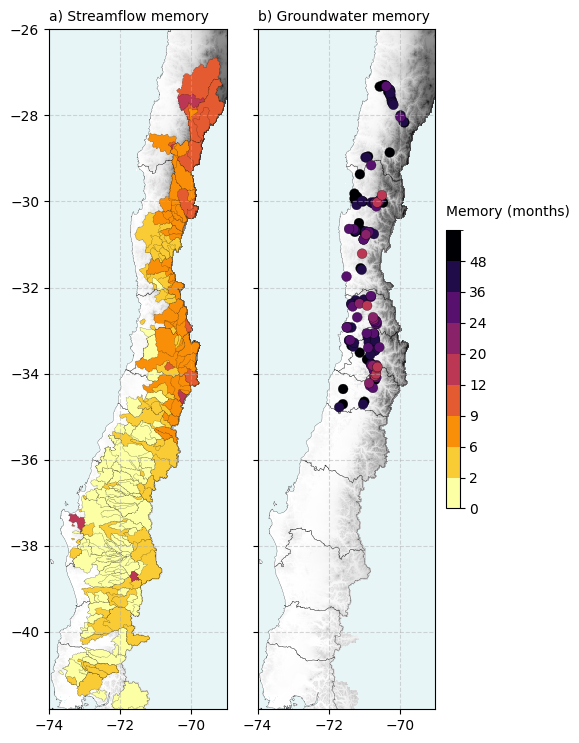

In [ ]:

# q_bins = np.quantile(q_vals_clean, np.linspace(0, 1, n_bins_q + 1))
# gw_bins = np.quantile(gw_vals_clean, np.linspace(0, 1, n_bins_gw + 1))

# Step 4: Merge, round, and ensure uniqueness
bins = np.round(np.unique(np.concatenate([q_bins, gw_bins])), 2)
bins[0] = 0  # ensure first bin starts at 0
cmap_list = cm.get_cmap('inferno')(np.linspace(1, 0, len(bins) - 1))
cmap = ListedColormap(cmap_list)
norm = BoundaryNorm(bins, cmap.N)
boundaries = bins

labels = [str(b) for b in bins[:-1]]  # Exclude the last bin
tick_positions = bins[:-1]            # Exclude the last bin


# === Map hydro memory values to bin indices using (a, b] logic ===
q_gpkg['bin_idx'] = pd.cut(
    q_gpkg['q_memory'],
    bins=bins,
    right=True,            # (a, b] intervals
    include_lowest=False,
    labels=False
)

gwl_gpkg['bin_idx'] = pd.cut(
    gwl_gpkg['gw_memory'],
    bins=bins,
    right=True,
    include_lowest=False,
    labels=False
)


# === Order by area (smallest on top) ===
# q_gpkg = q_gpkg.sort_values(by='area', ascending=True)
q_gpkg = q_gpkg.sort_values(by='area', ascending=False)
gwl_gpkg = gwl_gpkg.sort_values(by='gw_memory', ascending=False)

# === Define the bounding box (Chile region) ===
min_lon, max_lon = -74, -69
min_lat, max_lat = -41.8, -26.5
gwl_gpkg = gwl_gpkg[(gwl_gpkg.geometry.y <= max_lat) & (gwl_gpkg.geometry.y >= min_lat)]
q_gpkg = q_gpkg.cx[min_lon:max_lon, min_lat:max_lat]
elevation = elevation.sel(longitude=slice(min_lon, max_lon), latitude=slice(max_lat, min_lat))

# === Define the figure and axes (side by side) ===
fig = plt.figure(figsize=(12, 8))

width = 0.4
height = 0.85
x1 = 0.05
x2 = x1 + width - 0.22
x3 = x2 + width - 0.18

# === Create axes with manual placement ===
ax1 = fig.add_axes([x1, 0.1, width, height])  # [left, bottom, width, height]
ax2 = fig.add_axes([x2, 0.1, width, height])  # right panel slightly shifted
# ax3 = fig.add_axes([x3, 0.1, width, height])  # right panel slightly shifted

size_pt = 50

# === Plot blue ocean background ===
ax1.set_facecolor(to_rgba('powderblue', 0.3))
ax2.set_facecolor(to_rgba('powderblue', 0.3))

# === Plot the NetCDF elevation data ===
elevation.plot(ax=ax1, cmap='Greys', alpha=1, add_colorbar=False)
elevation.plot(ax=ax2, cmap='Greys', alpha=1, add_colorbar=False)

regions_gdf.plot(ax=ax1, edgecolor='black', facecolor='none', linewidth=0.2, alpha=0.8)
regions_gdf.plot(ax=ax2, edgecolor='black', facecolor='none', linewidth=0.2, alpha=0.8)

q_gpkg.plot(ax=ax1, column='bin_idx', cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(labels)-1),
            alpha=1, edgecolor='black', linewidth=0.1, label='Streamflow Memory')


gwl_gpkg.plot(ax=ax2, column='bin_idx', cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(labels)-1),
              markersize=size_pt, alpha=1, edgecolor='black', linewidth=0.2, label='Groundwater Memory')

# === Add titles ===
ax1.set_title('a) Streamflow memory', fontsize = 10, loc='left')
ax2.set_title('b) Groundwater memory', fontsize = 10, loc='left')
ax2.set_yticklabels('')

# === Common colorbar ===
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=[ax1, ax2], boundaries=boundaries,ticks=tick_positions, 
                    orientation='vertical', fraction=0.02, pad=0.015)

# === Set the labels correctly ===
cbar.ax.set_yticklabels(labels)
# cbar.set_label('Hydro Memory (months)')
cbar.ax.set_title("Memory (months)", fontsize = 10, loc='left', pad=10)

# === Remove axis labels and ticks ===
for ax in [ax1, ax2]:
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.grid(True, linestyle='--', alpha=0.5)

    # === Save the figure ===
plt.tight_layout()
plt.savefig('Fig_maps_GW_Q_memory.png', dpi=300, bbox_inches='tight')
plt.show()
